# Классификация вопросов на Stack Overflow

Этот набор данных, содержит 60000 вопросов, заданных на Stack Overflow. Вопросы подразделяются на три категории:

- `HQ`: Высококачественные посты с 30+ баллами и без единой правки.
- `LQ_CLOSE`: Посты низкого качества, которые были закрыты сообществом без единой правки.
- `LQ_EDIT`: Некачественные посты с отрицательной оценкой и многочисленными правками сообщества. Однако они все еще остаются открытыми после этих изменений.

In [16]:
import os
import re
from collections import Counter

import gensim.downloader as api
import keras
import keras.layers as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from gensim.models import KeyedVectors
from keras.backend import expand_dims
from nltk.tokenize import WordPunctTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

## Чтение данных

In [17]:
from google.colab import drive

drive.mount('/content/drive')
df = '/content/drive/My Drive/NLP/Data_lab1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
raw_data = pd.read_parquet(os.path.join(df, 'train.parquet'))

In [19]:
raw_data.shape

(48000, 4)

In [20]:
raw_data.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [21]:
raw_data.tail()

,Body,Tags,Title,target
Id,,,,
35488105,<p>Aspx Webpage accepting value in DD/mm/yyyy ...,<c#><asp.net><datetime><textbox>,textbox user control not displaying date in DD...,1
37045803,<p>I am making a program in C#. I want it to d...,<c#><image><detection>,C# do something based on image detection,1
43601747,"<p>The <a href=""https://kafka.apache.org/0100/...",<java><apache-kafka><kafka-producer-api>,KafkaProducer: Difference between `callback` a...,0
40505904,<p>Using the new pull request approval process...,<github>,Is there a way to make Github un-approve a pul...,0
40415937,i have taken three arrays one Array for saving...,<ios><objective-c><uitableview>,how to delete more than two Array Objects in t...,2


In [22]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 34862324 to 40415937
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    48000 non-null  object
 1   Tags    48000 non-null  object
 2   Title   48000 non-null  object
 3   target  48000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [23]:
raw_data.isnull().sum()

Body      0
Tags      0
Title     0
target    0
dtype: int64

Пропущенные значения отсутствуют.

## Exploratory Data Analysis

Объединим `Title` и `Body` поста в `Text`, а также удалим `Tags`

In [24]:
data = raw_data.copy()
data['Text'] = data['Title'] + " " + data['Body']
columns_to_drop = ['Tags', 'Title', 'Body']
data.drop(columns_to_drop, axis=1, inplace=True)

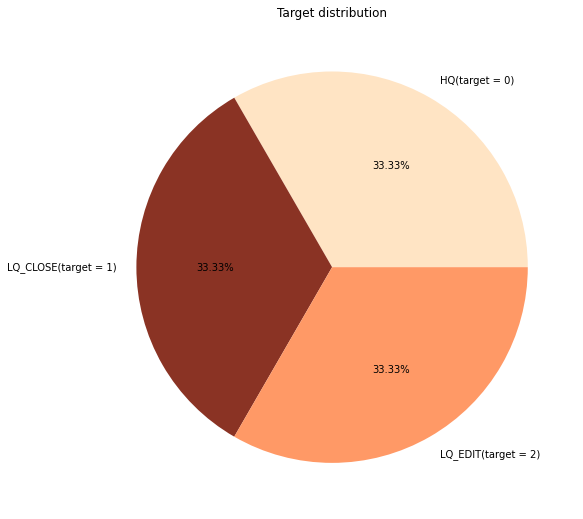

In [25]:
plt.figure(figsize=(16, 9))
colors_list = ['#ffe4c4', '#8a3324', '#ff9966']
plt.pie(data['target'].value_counts(),
        labels=['HQ(target = 0)', 'LQ_CLOSE(target = 1)', 'LQ_EDIT(target = 2)'],
        colors=colors_list,
        autopct='%.2f%%'
)
plt.title("Target distribution")
pass

Из круговой диаграммы можно сделать вывод, что классы сбалансированны.

In [26]:
def getTopNumberOfWords(corpus, n=15) -> pd.DataFrame:
    vec = CountVectorizer().fit(corpus)
    bow = vec.transform(corpus)
    bow = bow.sum(0)
    top = [(word, bow[0, index]) for word, index in vec.vocabulary_.items()]
    top = sorted(top, key=lambda x: x[1], reverse=True)
    top = pd.DataFrame(top[:n], columns=['Words', 'Count'])
    return top

text_ = getTopNumberOfWords(data['Text'])

fig = px.bar(text_, x='Words', y='Count')
fig.update_layout(title='The most common words in the text',
                  xaxis=dict(title='Words'),
                  yaxis=dict(title='Counts'))
fig.show()

## Предварительная обработка данных

Для повышения точности нашей модели, необходимо обработать данные, используя различные методы:




- Токенизация слов:

In [27]:
tokenizer = WordPunctTokenizer()
def word_tokenize(text):
  return ' '.join(tokenizer.tokenize(text))

- Удаление всех символов, кроме латиницы и пробелов + приведение текста к нижнему регистру:

In [28]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^(a-zA-Z)\s]','', text)
  return text

Выполним обработку `Text`:

In [29]:
data['Text'] = data['Text'].apply(clean_text)
data['Text'] = data['Text'].apply(word_tokenize)

In [30]:
data.head()

,target,Text
Id,,
34862324,2,i am implementing a minimum spanning forrest a...
47303682,2,r studio date is getting converted to number w...
46431243,0,pandas dataframe groupby how to get sum of mul...
45306324,0,casting results from observableforkjoin to the...
49479547,1,environment variable set in batch file cannot ...


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 34862324 to 40415937
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  48000 non-null  int64 
 1   Text    48000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


## Решение задачи классификации

## Разбиение данных на обучающую и тестовую выборки

In [32]:
target_data = data['target']
text_data = data.drop(['target'], axis=1)

In [33]:
data_train, data_test, target_train, target_test = train_test_split(text_data, target_data, test_size=0.25, random_state=21)

In [34]:
data_train.shape, data_test.shape, target_train.shape, target_test.shape

((36000, 1), (12000, 1), (36000,), (12000,))

In [35]:
data_train.head()

,Text
Id,
39673099,android nougat popupwindow showasdropdown () g...
51273359,javascript regex that matches words starting w...
43162629,( android appweb app ) ( noob ) how do i get s...
41039669,is there typescript definition for dom nativee...
45101571,error when i run the application in websphere ...


In [36]:
data_test.head()

,Text
Id,
56842217,scrape youtube video views pi have a list of y...
42447283,how to create table according to screenshoot u...
43617348,trying to center top navigation bar pmaking ad...
37007939,command line error d o and rtc commandline opt...
55390991,how to create a bit integer from eight () bit ...


In [37]:
data_train = data_train['Text']
data_test = data_test['Text']

target_train = target_train.values
target_test = target_test.values

## Классические методы векторизации данных

- Bag-of-words(BOW)

In [38]:
def BOW(train, test):
    bow_vectorizer = CountVectorizer()
    train_vec = bow_vectorizer.fit_transform(train)
    test_vec = bow_vectorizer.transform(test)
    return train_vec, test_vec


- Term Frequency-Inverse Document Frequency(tf-idf)

In [39]:
def tf_idf(train, test):
    tfidf_vectorizer = TfidfVectorizer()
    train_vec = tfidf_vectorizer.fit_transform(train)
    test_vec = tfidf_vectorizer.transform(test)
    return train_vec, test_vec

## Классические методы машинного обучения

- Линейная регрессия

In [40]:
vec_data_train, vec_data_test = BOW(data_train, data_test)
lrc = LogisticRegression(max_iter=700)
lrc.fit(vec_data_train, target_train)
vec_data_test_pr = lrc.predict(vec_data_test)
print(f1_score(target_test, vec_data_test_pr, average='macro'))
print(confusion_matrix(target_test, vec_data_test_pr, normalize='true'))


0.8788127252095609
[[0.82506992 0.16145436 0.01347572]
 [0.12812268 0.8320554  0.03982191]
 [0.00770378 0.0111829  0.98111332]]


In [41]:
vec_data_train, vec_data_test = tf_idf(data_train, data_test)
lrc = LogisticRegression(max_iter=700)
lrc.fit(vec_data_train, target_train)
vec_data_test_pr = lrc.predict(vec_data_test)
print(f1_score(target_test, vec_data_test_pr, average='macro'))
print(confusion_matrix(target_test, vec_data_test_pr, normalize='true'))

0.87410299255499
[[0.86066616 0.12560386 0.01372998]
 [0.13109077 0.7947069  0.07420233]
 [0.01963221 0.00944334 0.97092445]]


- Случайный лес

In [42]:
vec_data_train, vec_data_test = BOW(data_train, data_test)
rfc = RandomForestClassifier()
rfc.fit(vec_data_train, target_train)
vec_data_test_pr = rfc.predict(vec_data_test)
print(f1_score(target_test, vec_data_test_pr, average='macro'))
print(confusion_matrix(target_test, vec_data_test_pr, normalize='true'))

0.8202594803474025
[[0.72260361 0.25069921 0.02669718]
 [0.11872372 0.7712095  0.11006678]
 [0.01764414 0.00869781 0.97365805]]


In [43]:
vec_data_train, vec_data_test = tf_idf(data_train, data_test)
rfc = RandomForestClassifier()
rfc.fit(vec_data_train, target_train)
vec_data_test_pr = rfc.predict(vec_data_test)
print(f1_score(target_test, vec_data_test_pr, average='macro'))
print(confusion_matrix(target_test, vec_data_test_pr, normalize='true'))

0.8269119968897741
[[0.75565726 0.21917112 0.02517162]
 [0.13554291 0.7712095  0.09324759]
 [0.0221173  0.01963221 0.9582505 ]]


Исходя из полученных результатов, можно сделать вывод, что наилучший классификатор - линейная регрессия (f1_score = 0.87).

## Предобученные эмбединги

- w2v - используем модель от Google, обученную на новостных данных.

In [44]:
w2v_model = KeyedVectors.load_word2vec_format(os.path.join(df, 'GoogleNews-vectors-negative300.bin'), binary=True)

In [45]:
def w2v_vectorizer(train, test):
    return ([np.mean([w2v_model[word] for word in text.split() if word in w2v_model.vocab], axis=0) for text in train],
            [np.mean([w2v_model[word] for word in text.split() if word in w2v_model.vocab], axis=0) for text in test])

Применим векторизацию к классическим классификаторам

In [46]:
vec_data_train, vec_data_test = w2v_vectorizer(data_train, data_test)
lrc = LogisticRegression(max_iter=700)
lrc.fit(vec_data_train, target_train)
vec_data_test_pr = lrc.predict(vec_data_test)
print(f1_score(target_test, vec_data_test_pr, average='macro'))
print(confusion_matrix(target_test, vec_data_test_pr, normalize='true'))

0.7060800391279324
[[0.73455378 0.17620137 0.08924485]
 [0.20900322 0.58966114 0.20133564]
 [0.09294235 0.10437376 0.8026839 ]]


In [47]:
vec_data_train, vec_data_test = w2v_vectorizer(data_train, data_test)
rfc = RandomForestClassifier()
rfc.fit(vec_data_train, target_train)
vec_data_test_pr = rfc.predict(vec_data_test)
print(f1_score(target_test, vec_data_test_pr, average='macro'))
print(confusion_matrix(target_test, vec_data_test_pr, normalize='true'))

0.6238944447823749
[[0.67149758 0.20315281 0.12534961]
 [0.22161761 0.5243631  0.25401929]
 [0.13295229 0.18563618 0.68141153]]


- GloVe - используем модель, обученную на данных из Twitter.

In [48]:
glove_model = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [49]:
def glove_vectorizer(train, test):
    return ([np.sum([glove_model[word] for word in text.split() if word in glove_model.vocab], axis=0) for text in train],
            [np.sum([glove_model[word] for word in text.split() if word in glove_model.vocab], axis=0) for text in test])

In [50]:
vec_data_train, vec_data_test = glove_vectorizer(data_train, data_test)
lrc = LogisticRegression(max_iter=700)
lrc.fit(vec_data_train, target_train)
vec_data_test_pr = lrc.predict(vec_data_test)
print(f1_score(target_test, vec_data_test_pr, average='macro'))
print(confusion_matrix(target_test, vec_data_test_pr, normalize='true'))

0.5112754939931045
[[0.51665395 0.28527841 0.19806763]
 [0.23992085 0.5063072  0.25377195]
 [0.18489066 0.30641153 0.50869781]]


На предобученных эмбеддингах наилучший результат (f1_score = 0.7) получился при использовании w2v.

## Нейронная сеть

### Предварительная обработка данных

In [51]:
text_columns = ['Title', 'Body']
categorical_columns = ['Tags']
target_column = 'target'

Приведем весь текст в нижний регистр + токенизируем (будем хранить токенизированные данные в виде строки токенов, разделенных пробелами, по соображениям производительности):

In [52]:
nn_data = raw_data
nn_data['Body'] = nn_data['Body'].apply(str).apply(str.lower).apply(word_tokenize)
nn_data['Title'] = nn_data['Title'].apply(str).apply(str.lower).apply(word_tokenize)

In [53]:
nn_data['target'] = nn_data['target'].apply(lambda target: np.eye(3, dtype=np.int32)[target])

Посчитаем количество уникальных токенов:

In [54]:
token_counts = Counter()
for col in text_columns:
    for text in nn_data[col].values:
        token_counts.update(text.split(' '))

In [55]:
print('Всего уникальных токенов :', len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Всего уникальных токенов : 230236
('.', 543501)
('>', 375572)
('p', 225299)
('<', 215383)
(',', 202492)
...
('3bujt', 1)
('9i4jf', 1)
('__nscfarray', 1)


Посмотрим, сколько слов у каждого счетчика, построив гистограмму:

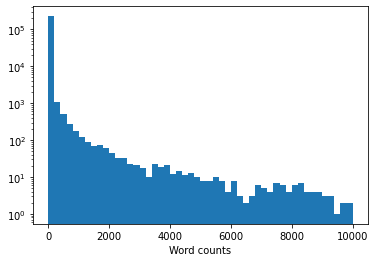

In [56]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Отфильтруем токены, которые встречаются не менее 10 раз:

In [57]:
min_count = 10
tokens = [token for token, count in token_counts.items() if count >= min_count]

Добавим специальные токены для неизвестных и пустых слов:

In [58]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Размер словарного запаса:", len(tokens))

Размер словарного запаса: 24477


Создадим обратный индекс токена:

In [59]:
token_to_id = {token: i for i, token in enumerate(tokens)}

Используем созданный словарь для отображения текстовых строк в матрицы, усваиваемые нейронной сетью:

In [60]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding

    Args:
        sequences (list): list of tokens
        max_len (int, optional): maximum length. Defaults to None.
    """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

Закодируем имеющиеся у нас категориальные данные:

In [61]:
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(nn_data[categorical_columns].apply(dict, axis=1))

top_types, top_counts = zip(*Counter(nn_data['Tags']).most_common(1000))
recognized_companies = set(top_types)

## The deep learning part

Разобьем данные на обучающую и валидационную выборку:

In [62]:
nn_data_train, nn_data_val = train_test_split(nn_data, test_size=0.25, random_state=21)
nn_data_train.index = range(len(nn_data_train))
nn_data_val.index = range(len(nn_data_val))

print('Train size = ', len(nn_data_train))
print('Validation size = ', len(nn_data_val))

Train size =  36000
Validation size =  12000


In [63]:
def convert_target_array(arr):
  result = np.zeros((len(arr), 3), dtype=np.int32)
  for i in range(len(arr)):
    for k in range(len(arr[i])):
      result[i, k] = arr[i][k]
  return result

In [64]:
def make_batch(data, max_len=None, word_dropout=0):
    """Creates a keras-friendly dict from the batch data.

    Args:
        data (pd.DataFrame): data set
        max_len (int, optional): maximum length. Defaults to None.
        word_dropout (int, optional): replaces token index with UNK_IX with this probability. Defaults to 0.

    Returns:
        dict: {'title' : int64[batch, title_max_len]}
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["Body"] = as_matrix(data["Body"].values, max_len)
    batch["target"] = convert_target_array(data["target"].values)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["Body"] = apply_word_dropout(batch["Body"], 1. - word_dropout)

    if target_column in ['Title', 'Body', 'Categorical']:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [65]:
{' ': convert_target_array(nn_data[:3]['target'].values)}
make_batch(nn_data_train[:3], max_len=10)

{'Body': array([[ 3378, 16759,  3569, 12276, 11902, 21908,  7071,  1414, 16759,
          3569],
        [ 3378, 16759,  3569, 12276,  4787, 22437, 22100, 23905,  4180,
         18633],
        [ 3378, 16759,  3569, 16328, 20420, 10573, 16300,  3187, 12276,
          4787]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Title': array([[ 4851, 16017, 17471,     0,   854, 11653, 15980, 23861,     1,
             1],
        [13282, 18633, 21855, 14636, 23843, 20820, 23788,  4180,  9175,
          1187],
        [  639,  4851,  4986,  1430, 23577,  4986,   903,   639, 15957,
           903]], dtype=int32),
 'target': array([[1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], dtype=int32)}

In [66]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    
    l_title = L.Input(shape=[None], name='Title')
    l_descr = L.Input(shape=[None], name='Body')
    l_categ = L.Input(shape=[n_cat_features], name='Categorical')
      
    emb = L.Embedding(n_tokens, hid_size)

    l_title_emb = emb(l_title)
    l_title_emb = L.Embedding(n_tokens, hid_size)(l_title)
    l_title_emb = L.GlobalMaxPool1D()(l_title_emb)

    l_descr_emb = emb(l_descr)
    l_descr_emb = L.Dense(2*hid_size)(l_descr_emb)
    l_descr_emb = L.GlobalMaxPool1D()(l_descr_emb)
    
    l_cat_emb = L.Dense(2*hid_size)(l_categ) #cat feature

    l_combined = L.Concatenate()([l_cat_emb, l_descr_emb, l_title_emb])
    l_combined = expand_dims(l_combined, 1)
    l_combined = L.Conv1D(filters=hid_size, kernel_size=3, activation='relu', padding='same')(l_combined)
    l_combined = L.GlobalMaxPool1D()(l_combined)
    l_combined = L.Dense(2*hid_size, activation='relu')(l_combined)

    output_layer = L.Dense(3)(l_combined)
    output_layer = L.Softmax()(output_layer)
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [67]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(nn_data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(nn_data_train[:100]),
                                  convert_target_array(nn_data_train['target'][:100]))[0]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Body (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     1566528     ['Body[0][0]']                   
                                                                                                  
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 Categorical (InputLayer)       [(None, 27249)]      0           []                               
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning:

Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.



In [68]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """Iterates minibatches of data in random order

    Args:
        data (pd.DataFrame): data set
        batch_size (int, optional): batch size. Defaults to 256.
        shuffle (bool, optional): data shuffle. Defaults to True.
        cycle (bool, optional): cycle. Defaults to False.

    Yields:
        batch, target
    """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [69]:
batch_size = 256
epochs = 5 
steps_per_epoch = 100 

model = build_model()

model.fit_generator(iterate_minibatches(nn_data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(nn_data_val, batch_size, cycle=True),
                    validation_steps=nn_data_val.shape[0] // batch_size
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/5
100/100 [==============================] - 21s 197ms/step - loss: 0.5868 - categorical_accuracy: 0.7995 - val_loss: 0.2119 - val_categorical_accuracy: 0.9144
Epoch 2/5
100/100 [==============================] - 22s 223ms/step - loss: 0.1409 - categorical_accuracy: 0.9482 - val_loss: 0.2139 - val_categorical_accuracy: 0.9202
Epoch 3/5
100/100 [==============================] - 21s 210ms/step - loss: 0.0835 - categorical_accuracy: 0.9730 - val_loss: 0.2025 - val_categorical_accuracy: 0.9235
Epoch 4/5
100/100 [==============================] - 20s 196ms/step - loss: 0.0406 - categorical_accuracy: 0.9852 - val_loss: 0.2027 - val_categorical_accuracy: 0.9226
Epoch 5/5
100/100 [==============================] - 21s 213ms/step - loss: 0.0235 - categorical_accuracy: 0.9924 - val_loss: 0.2266 - val_categorical_accuracy: 0.9215


## Вывод

После предобработки данных и обучения нейронной сети, была получена точность 0.9215.

Получим ответ для соревнования на Kaggle:

In [70]:
raw_data_test = pd.read_parquet(os.path.join(df, 'test.parquet'))
nn_data_test = raw_data_test
nn_data_test['Body'] = raw_data_test['Body'].apply(str).apply(str.lower).apply(word_tokenize)
nn_data_test['Title'] = raw_data_test['Title'].apply(str).apply(str.lower).apply(word_tokenize)
nn_data_test['Tags'] = nn_data_test['Tags'].apply(lambda companies: companies if companies in recognized_companies else 'Other')

In [71]:
def make_test_batch(data, max_len=None, word_dropout=0):
    batch = {}
    batch['Title'] = as_matrix(data['Title'].values, max_len)
    batch['Body'] = as_matrix(data['Body'].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
  
    if target_column in ['Title', 'Body', 'Categorical']:
        batch[target_column] = data[target_column].values
    return batch

In [72]:
pred = model.predict(make_test_batch(nn_data_test))

In [73]:
pred = list(map(np.argmax, pred))

In [74]:
submission = pd.DataFrame(data={'Id':nn_data_test.index.tolist(), 'Predicted': pred})

In [75]:
submission.to_csv(os.path.join(df, 'submission.csv'), index=False)